# 1. Import required libraries

In [1]:
%%capture
!pip install timm

In [2]:
import os
import PIL
import time
import timm
import math
import copy
import torch
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
import itertools
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim import lr_scheduler
from timm.models.layers.activations import *
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from tqdm import tqdm

# 2. Data Preparation

In [3]:
# Hyperparameters
batch_size = 32
num_epochs = 25

In [4]:
root_dir = '/kaggle/input/chest-xray-classification'
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [5]:
image_datasets = {x : datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
data_loader = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size if x!='test' else 2, shuffle=True, num_workers=2, pin_memory=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [6]:
print(dataset_sizes)
print(class_names)

{'train': 17813, 'val': 2227, 'test': 2229}
['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']


# 3. Model

In [7]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.head

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


Linear(in_features=1024, out_features=1000, bias=True)

In [8]:
from collections import OrderedDict
head = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(512, 256)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(256, 5))
]))
model.head = head
model = model.to(device)

for params in model.parameters():
    params.requires_grad = True
    
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_params(model))

87400637


# 4. Training

In [9]:
criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs , path='model.path'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.
    
    for epoch in range(num_epochs):
        since_e = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct = 0
            
            for i, (inputs, labels) in tqdm(enumerate(data_loader[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                if i%1000==999:
                    print(f"[{epoch+1}, {i} loss: {running_loss/(i*inputs.size(0)):.4f}]")
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item()*inputs.size(0)
                running_correct += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct / dataset_sizes[phase]
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                scheduler.step(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                print(f'New acc: {epoch_acc:.4f}, previous acc: {best_acc:.4f}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
        time_e = time.time() - since_e
        print(f'Training epoch {epoch+1} complete in: {time_e//60:.0f}m {time_e%60:.0f}s')
    time_elapsed = time.time()-since
    print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))
    
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/25


557it [06:46,  1.37it/s]

train loss: 0.9992 acc: 0.6850



70it [00:29,  2.36it/s]


val loss: 0.7708 acc: 0.8119
New acc: 0.8119, previous acc: 0.0000
Training epoch 1 complete in: 7m 17s
Epoch 2/25


557it [06:32,  1.42it/s]

train loss: 0.7785 acc: 0.8052



70it [00:24,  2.91it/s]


val loss: 0.6403 acc: 0.8774
New acc: 0.8774, previous acc: 0.8119
Training epoch 2 complete in: 6m 57s
Epoch 3/25


557it [06:33,  1.42it/s]

train loss: 0.7110 acc: 0.8379



70it [00:24,  2.87it/s]


val loss: 0.6325 acc: 0.8837
New acc: 0.8837, previous acc: 0.8774
Training epoch 3 complete in: 6m 59s
Epoch 4/25


557it [06:33,  1.42it/s]

train loss: 0.6762 acc: 0.8565



70it [00:25,  2.75it/s]


val loss: 0.6183 acc: 0.8900
New acc: 0.8900, previous acc: 0.8837
Training epoch 4 complete in: 6m 60s
Epoch 5/25


557it [06:32,  1.42it/s]

train loss: 0.6639 acc: 0.8622



70it [00:25,  2.74it/s]


val loss: 0.5610 acc: 0.9169
New acc: 0.9169, previous acc: 0.8900
Training epoch 5 complete in: 6m 59s
Epoch 6/25


557it [06:34,  1.41it/s]

train loss: 0.6293 acc: 0.8809



70it [00:25,  2.77it/s]

val loss: 0.5895 acc: 0.9088
Training epoch 6 complete in: 6m 60s
Epoch 7/25



557it [06:35,  1.41it/s]

train loss: 0.6154 acc: 0.8856



70it [00:24,  2.88it/s]


val loss: 0.5662 acc: 0.9178
New acc: 0.9178, previous acc: 0.9169
Training epoch 7 complete in: 7m 0s
Epoch 8/25


557it [06:37,  1.40it/s]

train loss: 0.6029 acc: 0.8945



70it [00:25,  2.70it/s]


val loss: 0.5684 acc: 0.9219
New acc: 0.9219, previous acc: 0.9178
Training epoch 8 complete in: 7m 4s
Epoch 9/25


557it [06:34,  1.41it/s]

train loss: 0.6001 acc: 0.8951



70it [00:25,  2.70it/s]

val loss: 0.5711 acc: 0.9178
Training epoch 9 complete in: 7m 1s
Epoch 10/25



557it [06:36,  1.41it/s]

train loss: 0.5928 acc: 0.9001



70it [00:25,  2.72it/s]


val loss: 0.5472 acc: 0.9286
New acc: 0.9286, previous acc: 0.9219
Training epoch 10 complete in: 7m 3s
Epoch 11/25


557it [06:38,  1.40it/s]

train loss: 0.5835 acc: 0.9027



70it [00:26,  2.66it/s]

val loss: 0.6290 acc: 0.8918
Training epoch 11 complete in: 7m 5s
Epoch 12/25



557it [06:35,  1.41it/s]

train loss: 0.5762 acc: 0.9072



70it [00:26,  2.68it/s]


val loss: 0.5245 acc: 0.9367
New acc: 0.9367, previous acc: 0.9286
Training epoch 12 complete in: 7m 2s
Epoch 13/25


557it [06:38,  1.40it/s]

train loss: 0.5663 acc: 0.9117



70it [00:24,  2.85it/s]

val loss: 0.5420 acc: 0.9264
Training epoch 13 complete in: 7m 3s
Epoch 14/25



557it [06:35,  1.41it/s]

train loss: 0.5687 acc: 0.9110



70it [00:25,  2.71it/s]

val loss: 0.5314 acc: 0.9313
Training epoch 14 complete in: 7m 2s
Epoch 15/25



557it [06:33,  1.41it/s]

train loss: 0.5634 acc: 0.9143



70it [00:24,  2.89it/s]


val loss: 0.5239 acc: 0.9371
New acc: 0.9371, previous acc: 0.9367
Training epoch 15 complete in: 6m 59s
Epoch 16/25


557it [06:33,  1.41it/s]

train loss: 0.5483 acc: 0.9211



70it [00:24,  2.88it/s]

val loss: 0.5656 acc: 0.9228
Training epoch 16 complete in: 6m 58s
Epoch 17/25



557it [06:36,  1.41it/s]

train loss: 0.5516 acc: 0.9204



70it [00:23,  2.97it/s]

val loss: 0.5175 acc: 0.9371
Training epoch 17 complete in: 7m 0s
Epoch 18/25



557it [06:37,  1.40it/s]

train loss: 0.5449 acc: 0.9242



70it [00:26,  2.69it/s]


val loss: 0.5232 acc: 0.9376
New acc: 0.9376, previous acc: 0.9371
Training epoch 18 complete in: 7m 5s
Epoch 19/25


557it [06:35,  1.41it/s]

train loss: 0.5489 acc: 0.9219



70it [00:26,  2.65it/s]


val loss: 0.5132 acc: 0.9394
New acc: 0.9394, previous acc: 0.9376
Training epoch 19 complete in: 7m 3s
Epoch 20/25


557it [06:36,  1.40it/s]

train loss: 0.5436 acc: 0.9224



70it [00:26,  2.62it/s]

val loss: 0.5344 acc: 0.9308
Training epoch 20 complete in: 7m 3s
Epoch 21/25



557it [06:34,  1.41it/s]

train loss: 0.5483 acc: 0.9216



70it [00:26,  2.66it/s]

val loss: 0.5220 acc: 0.9367
Training epoch 21 complete in: 7m 1s
Epoch 22/25



557it [06:34,  1.41it/s]

train loss: 0.5527 acc: 0.9187



70it [00:26,  2.60it/s]


val loss: 0.5126 acc: 0.9470
New acc: 0.9470, previous acc: 0.9394
Training epoch 22 complete in: 7m 3s
Epoch 23/25


557it [06:35,  1.41it/s]

train loss: 0.5363 acc: 0.9293



70it [00:26,  2.66it/s]

val loss: 0.5472 acc: 0.9250
Training epoch 23 complete in: 7m 2s
Epoch 24/25



557it [06:39,  1.39it/s]

train loss: 0.5379 acc: 0.9269



70it [00:26,  2.64it/s]

val loss: 0.5364 acc: 0.9362
Training epoch 24 complete in: 7m 7s
Epoch 25/25



557it [06:37,  1.40it/s]

train loss: 0.5349 acc: 0.9276



70it [00:27,  2.54it/s]

val loss: 0.5084 acc: 0.9439
Training epoch 25 complete in: 7m 5s
Training complete in: 175m 59s
Best val acc: 0.9470 Best val loss: 0.5126


# 5. Prediction on Test set

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# head = nn.Sequential(OrderedDict([
#     ('fc1', nn.Linear(1024, 512)),
#     ('relu1', nn.ReLU()),
#     ('fc2', nn.Linear(512, 256)),
#     ('relu2', nn.ReLU()),
#     ('fc3', nn.Linear(256, 5))
# ]))
# model.head = head
# model = model.to(device)

model.load_state_dict(torch.load('./model.path'))

<All keys matched successfully>

Testing complete in 0m 51s
              precision    recall  f1-score   support

           0    0.97965   0.93094   0.95467       362
           1    0.95321   0.91362   0.93299       602
           2    0.92328   0.97642   0.94911      1060
           3    0.99167   0.88148   0.93333       135
           4    1.00000   0.95714   0.97810        70

    accuracy                        0.94572      2229
   macro avg    0.96956   0.93192   0.94964      2229
weighted avg    0.94707   0.94572   0.94561      2229



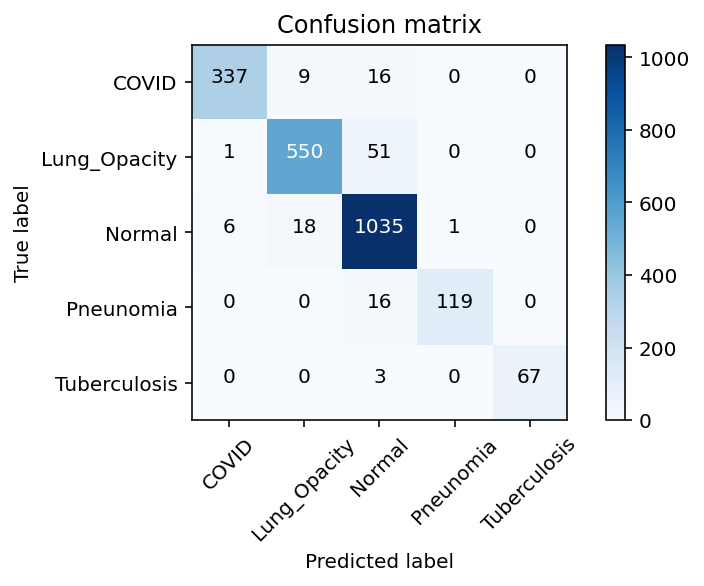

In [14]:
since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
time_elapsed = time.time() - since

print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

confusion_mtx = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plot_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_test, y_pred, digits=5)
print(report)